In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_csv('unvectorized_Human_AI_50k.csv')

In [ ]:
df.head()

,text,generated
0,Climate Change has become one of the most talk...,1
1,Public schools are not always the best to atte...,0
2,Should summer projects be designed by students...,0
3,The meaning of an democracy is that the people...,0
4,Limiting Car Usage Has Many Advantages Cars ar...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       49998 non-null  object
 1   generated  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49998 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       49998 non-null  object
 1   generated  49998 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
X = df['text']
y = df['generated']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)  # 75% training, 25% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)  # 60% of temp for test, 40% for validation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

In [ ]:
# Define the custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  # For BCEWithLogitsLoss
        return item

# Tokenize data
MAX_LEN = 512
train_encodings = tokenizer(list(X_train), padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
val_encodings = tokenizer(list(X_val), padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")
test_encodings = tokenizer(list(X_test), padding="max_length", truncation=True, max_length=MAX_LEN, return_tensors="pt")

# Prepare labels
train_labels = list(y_train)
val_labels = list(y_val)
test_labels = list(y_test)

# Create datasets
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class TinyBertClassifier(nn.Module):
    def __init__(self, base_model):
        super(TinyBertClassifier, self).__init__()
        self.base_model = base_model
        self.classifier = torch.nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Freeze TinyBERT during inference
            outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)

        # Pass the pooler output to the classification head
        logits = self.classifier(outputs.pooler_output)
        return logits

In [ ]:
class TinyBertClassifier(nn.Module):
    def __init__(self, base_model):
        super(TinyBertClassifier, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.3)  # Add dropout for regularization
        self.classifier = nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token embedding directly
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)
        return logits

In [ ]:
base_model = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

# Selectively freeze layers (unfreeze top 2 layers)
for param in base_model.parameters():
    param.requires_grad = False
for param in base_model.encoder.layer[-2:].parameters():
    param.requires_grad = True

# Create the custom model
model = TinyBertClassifier(base_model).to(device)
model.to(device)

TinyBertClassifier(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, el

In [ ]:
# Optimizer for classification head only
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Binary Cross Entropy Loss with logits
loss_fn = torch.nn.BCEWithLogitsLoss()

Epoch 1/5


<ipython-input-9-8d1a2b85aa13>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training loss: 0.1805
Validation loss: 0.1278, Validation accuracy: 0.9572
Epoch 2/5
Training loss: 0.0913
Validation loss: 0.0619, Validation accuracy: 0.9796
Epoch 3/5
Training loss: 0.0730
Validation loss: 0.0603, Validation accuracy: 0.9810
Epoch 4/5
Training loss: 0.0590
Validation loss: 0.0479, Validation accuracy: 0.9846
Epoch 5/5
Training loss: 0.0523
Validation loss: 0.0582, Validation accuracy: 0.9826
Total time taken: 1237.41 seconds


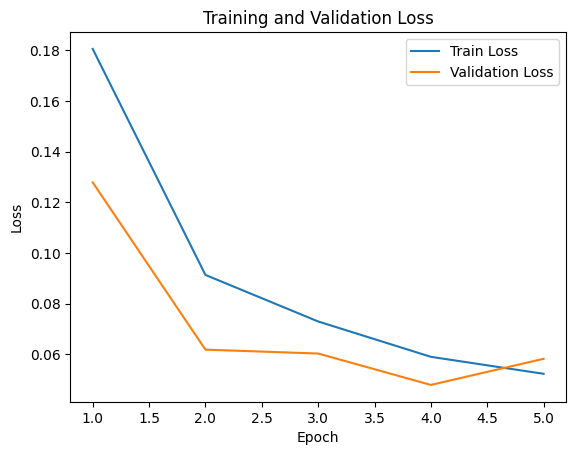

In [ ]:
# Training and validation loop
num_epochs = 5
train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss

        # Forward pass (no torch.no_grad() here)
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Only apply no_grad during validation
        for batch in val_loader:
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits.squeeze(-1), labels)
            val_loss += loss.item()

            # Calculate accuracy
            predictions = (torch.sigmoid(logits) > 0.5).long().squeeze(-1)
            correct_predictions += (predictions == labels.long()).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_predictions / total_predictions
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

# Plot losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'tinybert_model.pth')

In [ ]:
model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient calculation for faster testing (to save memory and computation)
with torch.no_grad():
    for batch in test_loader:  # Assuming test_loader is defined
        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss

        # Forward pass through the model
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Apply sigmoid and threshold for binary classification (0 or 1)
        predictions = (torch.sigmoid(logits) > 0.5).long().squeeze(-1)

        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_predictions, digits=4)
print(report)

<ipython-input-9-8d1a2b85aa13>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


              precision    recall  f1-score   support

         0.0     0.9715    0.9943    0.9828      3704
         1.0     0.9943    0.9715    0.9828      3796

    accuracy                         0.9828      7500
   macro avg     0.9829    0.9829    0.9828      7500
weighted avg     0.9831    0.9828    0.9828      7500

